# Section 6: Use case on COVID-19 demand for content
In this section, we use REGOMAX to quantify how the reach of hypergiants has been impacted by COVID-19

Recquired modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle

from matplotlib import ticker

import os
import networkx as nx
from pygomax import pygomax

Function used to plot reduced Google matrices 

In [2]:
def plot_G(ax, reduced_matrix, rnodes, rnodes_label, name, cmap_range=[]):
    """
    Plot a reduced_matrix.
    """
    
    ax.title.set_text(name+" = " + format(np.sum(reduced_matrix)/reduced_matrix.shape[0], ".6f"))
    if len(cmap_range) == 0:
        cmap_range = [np.min(reduced_matrix), np.max(reduced_matrix)]
    
    norm = mpl.colors.Normalize(vmin=cmap_range[0], vmax=cmap_range[1])
    cmap_obj = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    cmap = cmap_obj.cmap
    cm = ax.imshow(reduced_matrix, cmap="viridis")
    
    ax.set_xticks([i for i in range(reduced_matrix.shape[0])])
    ax.set_xticklabels(rnodes_label, rotation="90")
    ax.set_yticks([i for i in range(reduced_matrix.shape[0])])
    ax.set_yticklabels(rnodes_label)
    
    return cm

# Loading Data

In [3]:
BETA_H = 0.95
BETA_M = 0.75

I pickle january snapshot, that contains some post processing of the raw data (namely graph metric computations, country attribution, key player aka reduced nodes identification)

## Getting the graph

january pickle

In [4]:
prefix = "peeringdb_2_dump_"
date = "2020_01_01"

pickle_in = open("caida_pdbs/processed/clustered/"+prefix+date+".pickle","rb")
net, ix, nodes, DiGraph = pickle.load(pickle_in)
pickle_in.close()

Gmatrix = pygomax.GoogleMatrix(data=DiGraph, weighted=True)
GmatrixStar = pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=True)

june raw data loading

In [5]:
prefix = "peeringdb_2_dump_"
date = "2020_06_01"

pickle_in = open("caida_pdbs/processed/nodes/"+prefix+date+".pickle", "rb")
nodes_d2 = pickle.load(pickle_in)
pickle_in.close()
nodes_d2 = nodes_d2.loc[nodes_d2["port_capacity"]>0]

pickle_in = open("caida_pdbs/processed/ix/"+prefix+date+".pickle", "rb")
ix_d2 = pickle.load(pickle_in)
pickle_in.close()
ix_d2 = ix_d2.loc[ix_d2["port_capacity"]>0]

pickle_in = open("caida_pdbs/processed/net/"+prefix+date+".pickle", "rb")
net_d2 = pickle.load(pickle_in)
pickle_in.close()
net_d2 = net_d2.loc[net_d2["port_capacity"]>0]

BETA_H = 0.95
BETA_M = 0.75

edgelist = open("caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph_d2 = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")
GmatrixStar_d2 = pygomax.GoogleMatrix(data=DiGraph_d2.reverse(), weighted=True)

## Getting the reduced nodes

In [6]:
pickle_in = open("caida_pdbs/processed/clustered/rnodes.pickle","rb")
rnodes, rnodes_label = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("caida_pdbs/processed/clustered/rparams.pickle", "rb")
topCR, topKs, countries_list = pickle.load(pickle_in)
pickle_in.close()

topK = topKs[0] 

assert len(rnodes) == topCR + np.sum(topKs)

In [7]:
TableHypergiants = pd.DataFrame(index = rnodes[:topCR])
TableHypergiants["name"] = nodes.loc[rnodes[:topCR], "name"].values
TableHypergiants["asn"] = nodes.loc[rnodes[:topCR]].index
TableHypergiants["info_type"] = nodes.loc[rnodes[:topCR]].AStype
TableHypergiants

name     asn   info_type
32934                                        Facebook Inc   32934     Content
16509                                          Amazon.com   16509  Enterprise
20940                                 Akamai Technologies   20940     Content
15169                                          Google LLC   15169     Content
714                                            Apple Inc.     714     Content
8075                                            Microsoft    8075     Content
2906                                              Netflix    2906     Content
13335                                          Cloudflare   13335     Content
33438                               StackPath (Highwinds)   33438     Content
6939                                   Hurricane Electric    6939         NSP
54113                                        Fastly, Inc.   54113     Content
15133   Verizon Digital Media Services (EdgeCast Netwo...   15133     Content
16276                                            OVHcloud   16276     Content
22822                           Limelight Networks Global   22822     Content
10310                                              Yahoo!   10310     Content
32590                                   Valve Corporation   32590     Content
46489                                              Twitch   46489     Content
132203                                     Tencent Global  132203     Content
13414                                       Twitter, Inc.   13414     Content
52376                                          CABASE-RCN   52376  Non-Profit

In [8]:
pd.set_option('display.max_rows', 80)
codes = [0] * len(rnodes[topCR:])

count = 0 
for i in range(len(countries_list)):
    for j in range(topKs[i]):
        codes[count] = countries_list[i] + str(j+1)
        count += 1
        
TableCatchers = pd.DataFrame(index = rnodes[topCR:])
TableCatchers["name"] = nodes.loc[rnodes[topCR:], "name"].values
TableCatchers["asn"] = nodes.loc[rnodes[topCR:]].index
TableCatchers["info_type"] = nodes.loc[rnodes[topCR:]].AStype
TableCatchers["country"] = [code[:2] for code in codes]
TableCatchers["rank"] = [code[-1] for code in codes]
# TableCatchers["name"].to_csv("Traffic_catchers.csv")
# TableCatchers.head(50)
TableCatchers["codes"] = codes 
TableCatchers.set_index("codes")

name     asn      info_type country rank
codes                                                                         
US1                           T-Mobile USA   21928  Cable/DSL/ISP      US    1
US2                             Claro S.A.    4230            NSP      US    2
US3    Zayo (Abovenet Communications Inc.)    6461            NSP      US    3
US4                                   KDDI    2516            NSP      US    4
BR1                 Open X Tecnologia Ltda  263444            NSP      BR    1
BR2                                     G8   28329            NSP      BR    2
BR3                       Claro S.A. (NET)   28573  Cable/DSL/ISP      BR    3
BR4        Sistemax Brasil (Wiix Internet)  265950  Not Disclosed      BR    4
DE1      Telefónica Germany GmbH & Co. OHG    6805            NSP      DE    1
DE2                       Vodafone Germany    3209  Cable/DSL/ISP      DE    2
DE3        Saudi Telecom Company (STC IGW)   39386            NSP      DE    3
DE4        Vodafone Kabel Deutschland GmbH   31334  Cable/DSL/ISP      DE    4
NL1                              KPN-Netco    1136            NSP      NL    1
NL2                                   BICS    6774            NSP      NL    2
NL3                         T-Mobile Thuis   50266  Cable/DSL/ISP      NL    3
NL4                          Joint Transit   24785            NSP      NL    4
GB1    BTnet (BT's UK IP Network - AS2856)    2856            NSP      GB    1
GB2                               TalkTalk   13285  Cable/DSL/ISP      GB    2
GB3                          Sky Broadband    5607  Cable/DSL/ISP      GB    3
GB4                             Hyperoptic   56478  Cable/DSL/ISP      GB    4
FR1                   Bouygues Telecom ISP    5410  Cable/DSL/ISP      FR    1
FR2                              SFR Group   15557  Cable/DSL/ISP      FR    2
FR3                            Zayo France    8218            NSP      FR    3
FR4                                   moji  203698  Cable/DSL/ISP      FR    4
IT1          WIND Telecomunicazioni S.p.A.    1267            NSP      IT    1
IT2                                    NGI   35612  Cable/DSL/ISP      IT    2
IT3                                Fastweb   12874  Cable/DSL/ISP      IT    3
IT4                         Vodafone Italy   30722            NSP      IT    4
ES1                               MásMóvil   15704  Cable/DSL/ISP      ES    1
ES2                           Orange Spain   12479                     ES    2
ES3                        Vodafone España   12430  Cable/DSL/ISP      ES    3
ES4         Aire Networks del Mediterraneo   29119            NSP      ES    4
PL1                             Netia S.A.   12741            NSP      PL    1
PL2                                 VECTRA   29314  Cable/DSL/ISP      PL    2
PL3                   Polkomtel Sp. z o.o.    8374  Cable/DSL/ISP      PL    3
PL4                                Korbank   35179            NSP      PL    4
JP1                         SoftBank Corp.   17676            NSP      JP    1
JP2                        Level 3 AS 3356    3356            NSP      JP    2
JP3                                   Colt    8220            NSP      JP    3
JP4                           BIGLOBE Inc.    2518            NSP      JP    4

# Hypergiant diffusion difference

For dates = ["2019_01_01", "2019_06_01", "2020_01_01", "2020_06_01", "2021_01_01"]

We need extra care for nodes (namely ASN24785 Joint Transit) that are in 2020-01-01 snapshots but missing in others. If $n$ nodes are missing, the strategy is to compute regomax for the $n_r-n$ nodes, spot where these nodes used to be and fill 0s because we still want $G_R$ to be plotted with $n_r$ entries.  
My correction only works if hypergiants are in all snapshots, thankfully it is the case

In [9]:
common_cm = False
import matplotlib.colors

# Color for False and True
clrs = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1', '#C2E4EF',
        '#EAECCC', '#FEDA8B', '#FDB366', '#F67E4B', '#DD3D2D',
        '#A50026']
cmap_bin = matplotlib.colors.ListedColormap(['#364B9A', '#A50026'])

## colorblind friendly colormap
from matplotlib.colors import LinearSegmentedColormap

clrs = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1', '#C2E4EF',
        '#EAECCC', '#FEDA8B', '#FDB366', '#F67E4B', '#DD3D2D',
        '#A50026']
cmap_colorblind = LinearSegmentedColormap.from_list("div_color_blind", clrs)
cmap_colorblind.set_bad('#FFFFFF')

class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

**Helper functions for the analysis of the matrices**

In [10]:
def amin(array, reverse=True):
    """Return the args of numpy array values sorted by ascending order
    similar to numpy.argmin but I take care of flattening/reshaping"""
    idxs = [(i,j) for i in range(array.shape[0]) for j in range(array.shape[1])]
    flatten = list(array.flatten())
    return [idx for _,idx in sorted(zip(flatten,idxs), reverse=reverse)]

In [11]:
def print_capped(diff, vmin=-0.5, vmax=1.0):
    print()
    print("CAPPED LINKS")
    print("Positive changes capped by vmax = ", vmax)
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if diff[i,j] > vmax:
                print((rnodes_label[i], rnodes_label[topCR+j], diff[i,j]))
    
    print("Negative changes capped by vmin = ", vmin)
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if diff[i,j] < vmin:
                print((rnodes_label[i], rnodes_label[topCR+j], diff[i,j]))


def print_top_bot_changes(diff, K=10):
    print()
    print("TOP BOT CHANGES")
    negative_diff = amin(diff, reverse=False)[:K]
    positive_diff = amin(diff)[:K]

    print("Top negative changes", [(rnodes_label[couple[0]], rnodes_label[topCR+couple[1]], diff[couple[0], couple[1]]) for couple in negative_diff])
    print("Top positive changes", [(rnodes_label[couple[0]], rnodes_label[topCR+couple[1]], diff[couple[0], couple[1]]) for couple in positive_diff])
    
def print_hypergiants_investments(diff):
    print()
    print("HYPERGIANTS INVESTMENTS")
    investment = pd.Series([np.nansum(diff[i,:]) for i in range(topCR)], index = rnodes_label[:topCR])
    display(investment.sort_values(ascending=False))
    
def print_country_investments(diff):
    print()
    print("COUNTRY INVESTMENTS")
    investment = pd.Series([np.nansum(diff[:,i]) for i in range(len(countries_list))], countries_list)
    display(investment.sort_values(ascending=False))
    
def print_hypergiants_investments_in_countries_v1(diff):
    print()
    print("HYPERGIANTS INVESTMENTS IN COUNTRY")
    df = pd.DataFrame(index=rnodes_label[:topCR], columns=range(len(countries_list)))
    for i, hypergiant in enumerate(df.index):
        investment = pd.Series([np.nansum(diff[i,j*topK:(j+1)*topK]) for j in range(len(countries_list))],
                               index = countries_list).sort_values(ascending=False)
        df.loc[hypergiant, :] = [str(u)+' '+format(v,".2f") for u, v in investment.items()]
    display(df)

def print_hypergiants_investments_in_countries_v2(diff):
    print()
    print("COUNTRY INVESTMENTS")
#     investment = pd.Series({country: np.nansum(diff[:, i*topK:(i+1)*topK]) for i, country in enumerate(countries_list)})
    for i, country in enumerate(countries_list):
        investment = pd.Series([np.nansum(diff[j,i*topK:(i+1)*topK]) for j in range(topCR)], index = rnodes_label[:topCR])
        print(country)
        display(investment.sort_values(ascending=False))
        


**Procedure to build diffusion matrix differences**
1. For each snapshots, compute GR. Reduced nodes are selected for 2020_01_01 U 2020_06_01, so they might not be in other snapshots. We end up, for each snapshots, with a GR matrix of possible different sizes
2. We substract the diagonal and re-normalize GR, then select only the top right part (hypergiants diffusion to eyeball part, see previous sections)
3. We make all GR with the same dimensions : we insert row,col of zeros for a missing node
4. We compute the normalized difference (GR_d2-GR)./GR for each matrix elements

In [12]:
plt.rc('font',**{'family':'serif','serif':['Times'], 'size':12})
plt.rc('text', usetex=True)


 #####################################
2019_01_01 2019_06_01
#####################################

Missing rnode
asn
24785    Joint Transit
Name: name, dtype: object
Weight of Grr is  0.0009722069647369004
Weight of Gpr is  0.44073516193044354
Weight of Gqr is  0.5582927243415589
Weight of GR is  1.0000000932367392
Weight of Grr is  0.0009234140233722874
Weight of Gpr is  0.43763931811889567
Weight of Gqr is  0.5614375344247693
Weight of GR is  1.000000266567037
-----------------------------------
HELP FOR DATE 2019_06_01_2019_01_01
----------------------------------- 


CAPPED LINKS
Positive changes capped by vmax =  1.0
('Fastly', 'T-Mobile USA', 3.978980240525628)
('Fastly', 'G8', 1.3079592509224944)
('Fastly', 'Vodafone DE', 3.0763626671430204)
('Edgecast', 'Zayo France', 1.0948806392536303)
('OVHcloud', 'Zayo France', 4.588017821761449)
('Limelight Net. Global', 'Zayo France', 2.4205130255799348)
Negative changes capped by vmin =  -0.5
('Google', 'Zayo France', -0.61761698831354

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


Fastly                   9.884514
Tencent Global           8.716820
Netflix                  8.166823
Cloudflare               5.684302
Akamai                   2.837020
Microsoft                1.612077
Google                   1.545052
OVHcloud                 1.449772
Limelight Net. Global   -0.776630
StackPath               -1.071588
Apple                   -1.367349
Valve                   -1.377925
Facebook                -1.512947
CABASE-RCN              -1.622146
Edgecast                -1.687962
Amazon                  -1.925171
Hurricane Electric      -2.624134
Twitter                 -3.024650
Twitch                  -3.340456
Yahoo!                  -4.312899
dtype: float64


COUNTRY INVESTMENTS


FR    3.722782
US    3.333279
JP    3.067714
NL    0.455842
BR    0.424261
ES    0.350916
PL   -0.180279
GB   -0.368966
DE   -0.848398
IT   -0.905321
dtype: float64


HYPERGIANTS INVESTMENTS IN COUNTRY


0         1         2         3         4  \
Facebook                FR 0.31   GB 0.16  PL -0.09  NL -0.20  JP -0.20   
Amazon                  GB 0.45   BR 0.00  DE -0.19  IT -0.20  ES -0.24   
Akamai                  BR 0.79   JP 0.59   GB 0.53   IT 0.44   ES 0.34   
Google                  BR 0.68   PL 0.56   US 0.37   NL 0.32   GB 0.26   
Apple                   NL 0.10   BR 0.01  ES -0.01  US -0.09  DE -0.12   
Microsoft               GB 0.51   US 0.44   JP 0.34   DE 0.31   ES 0.18   
Netflix                 DE 2.17   IT 1.23   US 1.12   FR 1.05   BR 1.01   
Cloudflare              IT 1.20   GB 1.00   DE 0.85   JP 0.69   PL 0.56   
StackPath               ES 0.48   BR 0.47   JP 0.03  NL -0.09  PL -0.11   
Hurricane Electric     JP -0.09  GB -0.16  DE -0.17  NL -0.17  BR -0.19   
Fastly                  US 4.02   DE 3.21   BR 1.11   JP 0.89   IT 0.64   
Edgecast                FR 0.91  US -0.06  JP -0.13  NL -0.13  BR -0.21   
OVHcloud                FR 4.44  JP -0.17  PL -0.21  GB -0.24  NL -0.25   
Limelight Net. Global   FR 2.24   GB 0.81  PL -0.29  NL -0.34  BR -0.37   
Yahoo!                 FR -0.12  BR -0.18  NL -0.34  PL -0.40  IT -0.48   
Valve                   FR 0.64   IT 0.07  US -0.03  BR -0.08  JP -0.14   
Twitch                  FR 0.49  PL -0.22  NL -0.33  JP -0.36  IT -0.42   
Tencent Global          PL 1.46   JP 1.16   IT 1.11   US 1.01   FR 0.99   
Twitter                 FR 0.49  GB -0.11  BR -0.12  NL -0.24  IT -0.31   
CABASE-RCN             BR -0.04  GB -0.10  JP -0.13  IT -0.13  NL -0.14   

                              5         6         7         8         9  
Facebook               IT -0.21  US -0.29  BR -0.31  DE -0.33  ES -0.36  
Amazon                 NL -0.28  PL -0.29  JP -0.34  FR -0.37  US -0.48  
Akamai                  PL 0.25   US 0.19   NL 0.06   DE 0.02  FR -0.37  
Google                  ES 0.11   JP 0.03   DE 0.03  IT -0.09  FR -0.71  
Apple                  PL -0.15  JP -0.17  GB -0.24  IT -0.34  FR -0.35  
Microsoft               PL 0.13   BR 0.10   IT 0.02   NL 0.01  FR -0.43  
Netflix                 ES 0.55   JP 0.53   NL 0.23   GB 0.15   PL 0.12  
Cloudflare              ES 0.48   NL 0.47   BR 0.39   US 0.27  FR -0.22  
StackPath              IT -0.14  US -0.22  FR -0.32  DE -0.48  GB -0.70  
Hurricane Electric     PL -0.20  IT -0.26  ES -0.32  US -0.33  FR -0.74  
Fastly                  FR 0.33   PL 0.21   NL 0.03   ES 0.00  GB -0.57  
Edgecast               IT -0.26  GB -0.28  ES -0.38  DE -0.47  PL -0.68  
OVHcloud               IT -0.25  ES -0.26  US -0.33  BR -0.61  DE -0.67  
Limelight Net. Global  IT -0.44  JP -0.53  US -0.56  DE -0.64  ES -0.66  
Yahoo!                 JP -0.51  US -0.54  DE -0.56  GB -0.57  ES -0.63  
Valve                  GB -0.19  PL -0.30  NL -0.31  DE -0.45  ES -0.58  
Twitch                 US -0.43  BR -0.45  ES -0.52  GB -0.52  DE -0.58  
Tencent Global          BR 0.78   GB 0.66   ES 0.59   NL 0.49   DE 0.47  
Twitter                JP -0.41  US -0.45  ES -0.59  DE -0.60  PL -0.69  
CABASE-RCN             DE -0.16  ES -0.18  PL -0.19  US -0.26  FR -0.30


COUNTRY INVESTMENTS
US


Fastly                   4.022171
Netflix                  1.119705
Tencent Global           1.009873
Microsoft                0.441497
Google                   0.367781
Cloudflare               0.265844
Akamai                   0.190809
Valve                   -0.030107
Edgecast                -0.059075
Apple                   -0.085151
StackPath               -0.221223
CABASE-RCN              -0.258487
Facebook                -0.285357
Hurricane Electric      -0.327402
OVHcloud                -0.329232
Twitch                  -0.431351
Twitter                 -0.445969
Amazon                  -0.479033
Yahoo!                  -0.540122
Limelight Net. Global   -0.560186
dtype: float64

BR


Fastly                   1.114943
Netflix                  1.010111
Akamai                   0.790517
Tencent Global           0.782198
Google                   0.681111
StackPath                0.472742
Cloudflare               0.394098
Microsoft                0.100398
Apple                    0.005383
Amazon                   0.002267
CABASE-RCN              -0.044954
Valve                   -0.083224
Twitter                 -0.118462
Yahoo!                  -0.176750
Hurricane Electric      -0.190886
Edgecast                -0.207183
Facebook                -0.306675
Limelight Net. Global   -0.366716
Twitch                  -0.452398
OVHcloud                -0.607110
dtype: float64

DE


Fastly                   3.208225
Netflix                  2.174827
Cloudflare               0.853856
Tencent Global           0.469618
Microsoft                0.312240
Google                   0.030587
Akamai                   0.023860
Apple                   -0.122086
CABASE-RCN              -0.156177
Hurricane Electric      -0.167122
Amazon                  -0.185836
Facebook                -0.330959
Valve                   -0.454994
Edgecast                -0.468469
StackPath               -0.475952
Yahoo!                  -0.556648
Twitch                  -0.575226
Twitter                 -0.598394
Limelight Net. Global   -0.640744
OVHcloud                -0.669742
dtype: float64

NL


Tencent Global           0.487144
Cloudflare               0.470634
Google                   0.321072
Netflix                  0.227590
Apple                    0.096716
Akamai                   0.057153
Fastly                   0.034647
Microsoft                0.009523
StackPath               -0.090558
Edgecast                -0.134599
CABASE-RCN              -0.141096
Hurricane Electric      -0.172679
Facebook                -0.200158
Twitter                 -0.235821
OVHcloud                -0.246957
Amazon                  -0.276933
Valve                   -0.310074
Twitch                  -0.332131
Yahoo!                  -0.335031
Limelight Net. Global   -0.344077
dtype: float64

GB


Cloudflare               0.995023
Limelight Net. Global    0.813903
Tencent Global           0.655742
Akamai                   0.527655
Microsoft                0.512444
Amazon                   0.454458
Google                   0.255042
Facebook                 0.159196
Netflix                  0.148894
CABASE-RCN              -0.100339
Twitter                 -0.111725
Hurricane Electric      -0.161320
Valve                   -0.188103
Apple                   -0.239021
OVHcloud                -0.243924
Edgecast                -0.279082
Twitch                  -0.522561
Fastly                  -0.565887
Yahoo!                  -0.568540
StackPath               -0.703121
dtype: float64

FR


OVHcloud                 4.437366
Limelight Net. Global    2.237719
Netflix                  1.052851
Tencent Global           0.993595
Edgecast                 0.912287
Valve                    0.637803
Twitch                   0.492840
Twitter                  0.489264
Fastly                   0.326226
Facebook                 0.307687
Yahoo!                  -0.121083
Cloudflare              -0.220578
CABASE-RCN              -0.298477
StackPath               -0.317946
Apple                   -0.352280
Akamai                  -0.370990
Amazon                  -0.373850
Microsoft               -0.430676
Google                  -0.712318
Hurricane Electric      -0.736101
dtype: float64

IT


Netflix                  1.230101
Cloudflare               1.198705
Tencent Global           1.106327
Fastly                   0.635367
Akamai                   0.436616
Valve                    0.068715
Microsoft                0.016531
Google                  -0.094764
CABASE-RCN              -0.131531
StackPath               -0.140585
Amazon                  -0.198420
Facebook                -0.206345
OVHcloud                -0.247579
Hurricane Electric      -0.257330
Edgecast                -0.264297
Twitter                 -0.309154
Apple                   -0.336279
Twitch                  -0.423041
Limelight Net. Global   -0.435027
Yahoo!                  -0.475533
dtype: float64

ES


Tencent Global           0.593011
Netflix                  0.550969
Cloudflare               0.482184
StackPath                0.477309
Akamai                   0.343097
Microsoft                0.177946
Google                   0.106021
Fastly                   0.002839
Apple                   -0.014398
CABASE-RCN              -0.175239
Amazon                  -0.237651
OVHcloud                -0.260866
Hurricane Electric      -0.323009
Facebook                -0.356595
Edgecast                -0.377210
Twitch                  -0.522295
Valve                   -0.579576
Twitter                 -0.590608
Yahoo!                  -0.628712
Limelight Net. Global   -0.659320
dtype: float64

PL


Tencent Global           1.459519
Cloudflare               0.559467
Google                   0.559286
Akamai                   0.253089
Fastly                   0.213578
Microsoft                0.129938
Netflix                  0.122167
Facebook                -0.090649
StackPath               -0.105405
Apple                   -0.150478
CABASE-RCN              -0.188538
Hurricane Electric      -0.196218
OVHcloud                -0.210813
Twitch                  -0.218030
Limelight Net. Global   -0.287649
Amazon                  -0.288861
Valve                   -0.295400
Yahoo!                  -0.398763
Edgecast                -0.679509
Twitter                 -0.693332
dtype: float64

JP


Tencent Global           1.159791
Fastly                   0.892405
Cloudflare               0.685068
Akamai                   0.585215
Netflix                  0.529608
Microsoft                0.342236
StackPath                0.033151
Google                   0.031234
Hurricane Electric      -0.092068
CABASE-RCN              -0.127306
Edgecast                -0.130825
Valve                   -0.142964
Apple                   -0.169754
OVHcloud                -0.171372
Facebook                -0.203091
Amazon                  -0.341311
Twitch                  -0.356263
Twitter                 -0.410450
Yahoo!                  -0.511717
Limelight Net. Global   -0.534532
dtype: float64

diff sum 15.252522371074514


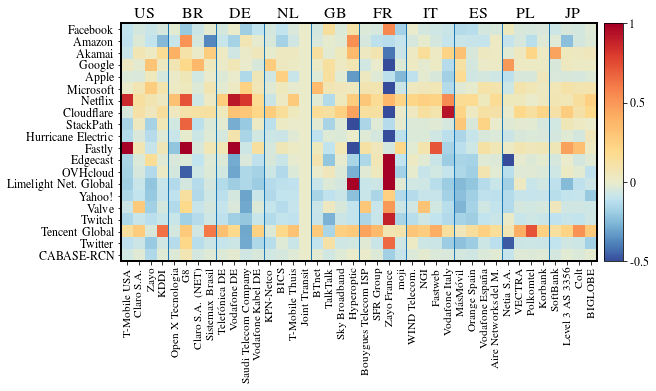


 #####################################
2019_06_01 2020_01_01
#####################################

Missing rnode
asn
24785    Joint Transit
Name: name, dtype: object
Weight of Grr is  0.0009234140233722874
Weight of Gpr is  0.43763931811889567
Weight of Gqr is  0.5614375344247693
Weight of GR is  1.000000266567037
Weight of Grr is  0.0008525190251420864
Weight of Gpr is  0.4520573311327064
Weight of Gqr is  0.5470903025063314
Weight of GR is  1.00000015266418
-----------------------------------
HELP FOR DATE 2020_01_01_2019_06_01
----------------------------------- 


CAPPED LINKS
Positive changes capped by vmax =  1.0
('Microsoft', 'T-Mobile USA', 1.40035109172154)
('Microsoft', 'Vodafone DE', 1.2808318686691753)
('Microsoft', 'Zayo France', 1.7924089562586127)
('Microsoft', 'Orange Spain', 1.0480850161779336)
('Fastly', 'G8', 1.0999086680984849)
('Fastly', 'BICS', 1.9431503842493056)
('Fastly', 'Zayo France', 5.130785473887275)
('Fastly', 'moji', 1.5684448162796762)
('Fastly', 'Ora

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


Fastly                   24.124270
Microsoft                12.129984
Edgecast                 10.297740
Tencent Global            5.336064
Amazon                    4.040115
Valve                     2.456340
Akamai                    2.247312
Limelight Net. Global     1.351041
Facebook                 -1.565272
Google                   -1.602706
Netflix                  -1.701705
Hurricane Electric       -1.969688
StackPath                -2.047548
CABASE-RCN               -2.718286
OVHcloud                 -3.158405
Apple                    -3.341543
Twitch                   -3.993989
Yahoo!                   -4.454434
Cloudflare               -5.046226
Twitter                  -5.506444
dtype: float64


COUNTRY INVESTMENTS


IT    1.575447
NL    0.689107
DE    0.658850
FR    0.559761
PL    0.497768
JP    0.480678
ES    0.337625
US    0.291918
BR   -0.032372
GB   -0.831638
dtype: float64


HYPERGIANTS INVESTMENTS IN COUNTRY


0         1         2         3         4  \
Facebook               BR -0.01  IT -0.06  NL -0.07  US -0.11  PL -0.11   
Amazon                  JP 0.80   PL 0.48   NL 0.48   DE 0.42   ES 0.39   
Akamai                  JP 0.52   IT 0.48   US 0.25   ES 0.22   FR 0.20   
Google                 IT -0.04  DE -0.06  ES -0.10  US -0.13  GB -0.13   
Apple                  DE -0.15  BR -0.22  IT -0.26  NL -0.35  GB -0.35   
Microsoft               FR 2.74   US 1.95   DE 1.67   ES 1.64   BR 1.32   
Netflix                 FR 0.16  ES -0.01  GB -0.04  BR -0.13  JP -0.13   
Cloudflare             NL -0.39  ES -0.42  US -0.43  IT -0.44  PL -0.48   
StackPath               DE 0.30  NL -0.04  GB -0.11  BR -0.15  PL -0.26   
Hurricane Electric     US -0.06  NL -0.16  BR -0.17  IT -0.17  JP -0.18   
Fastly                  FR 7.76   ES 3.20   PL 2.37   NL 2.30   BR 2.04   
Edgecast                PL 2.85   NL 2.40   GB 2.19   BR 0.85   IT 0.84   
OVHcloud                GB 0.47  JP -0.07  US -0.16  NL -0.34  DE -0.34   
Limelight Net. Global   JP 1.34   NL 0.84   IT 0.13   ES 0.11   PL 0.06   
Yahoo!                 US -0.33  NL -0.36  IT -0.40  BR -0.44  PL -0.44   
Valve                   PL 1.25   BR 0.99   US 0.56   NL 0.40   GB 0.37   
Twitch                 DE -0.20  NL -0.35  US -0.37  ES -0.38  PL -0.41   
Tencent Global          ES 1.02   JP 0.73   US 0.71   IT 0.71   DE 0.58   
Twitter                DE -0.29  NL -0.45  IT -0.48  US -0.51  GB -0.53   
CABASE-RCN             ES -0.21  US -0.22  IT -0.23  NL -0.23  GB -0.27   

                              5         6         7         8         9  
Facebook               DE -0.14  ES -0.17  GB -0.17  JP -0.36  FR -0.36  
Amazon                  GB 0.37   IT 0.29   FR 0.29   US 0.28   BR 0.25  
Akamai                  BR 0.19   GB 0.16   PL 0.14   NL 0.06   DE 0.02  
Google                 PL -0.18  NL -0.18  BR -0.25  FR -0.26  JP -0.27  
Apple                  PL -0.37  US -0.37  FR -0.40  ES -0.41  JP -0.47  
Microsoft               JP 1.27   IT 0.58   PL 0.47   GB 0.42   NL 0.06  
Netflix                PL -0.20  NL -0.24  US -0.31  IT -0.39  DE -0.40  
Cloudflare             BR -0.51  GB -0.53  JP -0.54  FR -0.58  DE -0.72  
StackPath              FR -0.27  IT -0.29  ES -0.37  US -0.42  JP -0.45  
Hurricane Electric     ES -0.19  GB -0.21  FR -0.26  PL -0.27  DE -0.31  
Fastly                  GB 1.73   JP 1.51   DE 1.39   US 1.03   IT 0.79  
Edgecast                JP 0.75   DE 0.53   US 0.38   ES 0.03  FR -0.51  
OVHcloud               ES -0.40  PL -0.43  BR -0.58  IT -0.59  FR -0.72  
Limelight Net. Global  DE -0.04  US -0.12  GB -0.12  BR -0.24  FR -0.62  
Yahoo!                 GB -0.44  ES -0.46  JP -0.46  FR -0.55  DE -0.58  
Valve                   IT 0.12  DE -0.14  FR -0.30  ES -0.35  JP -0.44  
Twitch                 JP -0.41  GB -0.42  IT -0.42  BR -0.46  FR -0.58  
Tencent Global          FR 0.51   GB 0.35   PL 0.34   NL 0.32   BR 0.07  
Twitter                PL -0.55  BR -0.61  JP -0.65  FR -0.70  ES -0.74  
CABASE-RCN             DE -0.28  BR -0.29  JP -0.31  PL -0.32  FR -0.36


COUNTRY INVESTMENTS
US


Microsoft                1.952905
Fastly                   1.026462
Tencent Global           0.711306
Valve                    0.555577
Edgecast                 0.377204
Amazon                   0.281859
Akamai                   0.251010
Hurricane Electric      -0.061032
Facebook                -0.112374
Limelight Net. Global   -0.117098
Google                  -0.126818
OVHcloud                -0.163156
CABASE-RCN              -0.220003
Netflix                 -0.314918
Yahoo!                  -0.331829
Twitch                  -0.367994
Apple                   -0.374711
StackPath               -0.415377
Cloudflare              -0.432893
Twitter                 -0.510616
dtype: float64

BR


Fastly                   2.041500
Microsoft                1.316627
Valve                    0.985659
Edgecast                 0.851080
Amazon                   0.248841
Akamai                   0.185221
Tencent Global           0.065848
Facebook                -0.006734
Netflix                 -0.128589
StackPath               -0.149595
Hurricane Electric      -0.170089
Apple                   -0.222576
Limelight Net. Global   -0.240161
Google                  -0.247430
CABASE-RCN              -0.288722
Yahoo!                  -0.435395
Twitch                  -0.461746
Cloudflare              -0.513304
OVHcloud                -0.582339
Twitter                 -0.606903
dtype: float64

DE


Microsoft                1.667724
Fastly                   1.390052
Tencent Global           0.584260
Edgecast                 0.528367
Amazon                   0.422509
StackPath                0.299628
Akamai                   0.020061
Limelight Net. Global   -0.042914
Google                  -0.059339
Valve                   -0.135103
Facebook                -0.139547
Apple                   -0.148058
Twitch                  -0.196245
CABASE-RCN              -0.278068
Twitter                 -0.292308
Hurricane Electric      -0.309159
OVHcloud                -0.341893
Netflix                 -0.404669
Yahoo!                  -0.576533
Cloudflare              -0.720703
dtype: float64

NL


Edgecast                 2.401003
Fastly                   2.302605
Limelight Net. Global    0.842320
Amazon                   0.476791
Valve                    0.402999
Tencent Global           0.324349
Microsoft                0.063823
Akamai                   0.057956
StackPath               -0.039972
Facebook                -0.067985
Hurricane Electric      -0.156887
Google                  -0.180579
CABASE-RCN              -0.233308
Netflix                 -0.237196
OVHcloud                -0.337209
Apple                   -0.346336
Twitch                  -0.346581
Yahoo!                  -0.356057
Cloudflare              -0.393733
Twitter                 -0.451620
dtype: float64

GB


Edgecast                 2.185382
Fastly                   1.733606
OVHcloud                 0.473621
Microsoft                0.421902
Valve                    0.370687
Amazon                   0.370087
Tencent Global           0.348966
Akamai                   0.161558
Netflix                 -0.040554
StackPath               -0.109744
Limelight Net. Global   -0.117487
Google                  -0.131268
Facebook                -0.171798
Hurricane Electric      -0.208246
CABASE-RCN              -0.268923
Apple                   -0.347884
Twitch                  -0.416140
Yahoo!                  -0.439229
Cloudflare              -0.529301
Twitter                 -0.533383
dtype: float64

FR


Fastly                   7.762695
Microsoft                2.744459
Tencent Global           0.505804
Amazon                   0.285546
Akamai                   0.198850
Netflix                  0.158811
Hurricane Electric      -0.255071
Google                  -0.261617
StackPath               -0.266404
Valve                   -0.304417
CABASE-RCN              -0.360436
Facebook                -0.364450
Apple                   -0.395234
Edgecast                -0.507220
Yahoo!                  -0.553473
Cloudflare              -0.575078
Twitch                  -0.582679
Limelight Net. Global   -0.620948
Twitter                 -0.704719
OVHcloud                -0.721158
dtype: float64

IT


Edgecast                 0.835845
Fastly                   0.789787
Tencent Global           0.707219
Microsoft                0.575761
Akamai                   0.482879
Amazon                   0.286339
Limelight Net. Global    0.134351
Valve                    0.122136
Google                  -0.044829
Facebook                -0.057644
Hurricane Electric      -0.171025
CABASE-RCN              -0.225142
Apple                   -0.256935
StackPath               -0.285939
Netflix                 -0.385881
Yahoo!                  -0.404551
Twitch                  -0.419424
Cloudflare              -0.435368
Twitter                 -0.478111
OVHcloud                -0.590492
dtype: float64

ES


Fastly                   3.201759
Microsoft                1.642484
Tencent Global           1.017557
Amazon                   0.390584
Akamai                   0.224951
Limelight Net. Global    0.113950
Edgecast                 0.026716
Netflix                 -0.012344
Google                  -0.101695
Facebook                -0.168390
Hurricane Electric      -0.190472
CABASE-RCN              -0.210731
Valve                   -0.347950
StackPath               -0.365884
Twitch                  -0.382145
OVHcloud                -0.397262
Apple                   -0.407407
Cloudflare              -0.424110
Yahoo!                  -0.457035
Twitter                 -0.736199
dtype: float64

PL


Edgecast                 2.847471
Fastly                   2.366287
Valve                    1.247100
Amazon                   0.480214
Microsoft                0.472878
Tencent Global           0.337614
Akamai                   0.143460
Limelight Net. Global    0.063659
Facebook                -0.113547
Google                  -0.175406
Netflix                 -0.202584
StackPath               -0.260876
Hurricane Electric      -0.266408
CABASE-RCN              -0.323963
Apple                   -0.371884
Twitch                  -0.410193
OVHcloud                -0.427126
Yahoo!                  -0.437334
Cloudflare              -0.483063
Twitter                 -0.546253
dtype: float64

JP


Fastly                   1.509515
Limelight Net. Global    1.335368
Microsoft                1.271421
Amazon                   0.797345
Edgecast                 0.751893
Tencent Global           0.733141
Akamai                   0.521366
OVHcloud                -0.071391
Netflix                 -0.133782
Hurricane Electric      -0.181298
Google                  -0.273726
CABASE-RCN              -0.308991
Facebook                -0.362804
Twitch                  -0.410841
Valve                   -0.440349
StackPath               -0.453386
Yahoo!                  -0.462996
Apple                   -0.470520
Cloudflare              -0.538673
Twitter                 -0.646332
dtype: float64

diff sum 24.87662025125325


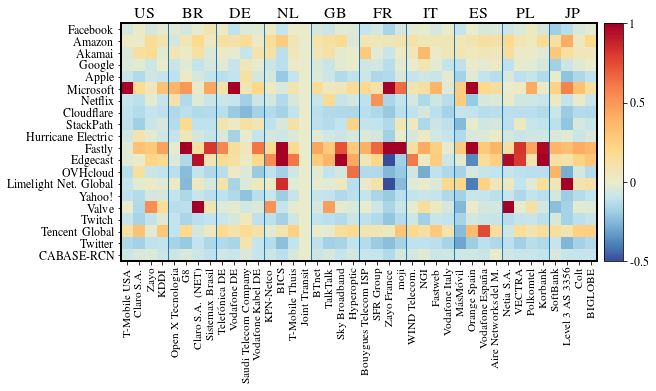


 #####################################
2020_01_01 2020_06_01
#####################################

Missing rnode
Weight of Grr is  0.0008669685001444947
Weight of Gpr is  0.44964156272291866
Weight of Gqr is  0.5494916264475186
Weight of GR is  1.0000001576705817
Weight of Grr is  0.0008181074447777476
Weight of Gpr is  0.46325619662313866
Weight of Gqr is  0.5359257843772142
Weight of GR is  1.0000000884451306
-----------------------------------
HELP FOR DATE 2020_06_01_2020_01_01
----------------------------------- 


CAPPED LINKS
Positive changes capped by vmax =  1.0
('Netflix', 'Zayo France', 1.0348309483846114)
('Netflix', 'WIND Telecom.', 1.0719395674373189)
Negative changes capped by vmin =  -0.5

TOP BOT CHANGES
Top negative changes [('OVHcloud', 'SFR Group', -0.4655580559884163), ('Twitter', 'Vodafone España', -0.4436451411945196), ('StackPath', 'G8', -0.41994384100878274), ('Amazon', 'Fastweb', -0.40501067788231004), ('OVHcloud', 'Orange Spain', -0.35634792901935713), ('Li

Netflix                  15.380685
Microsoft                 6.056423
Fastly                    3.356552
Edgecast                  2.092772
Facebook                  1.493841
Hurricane Electric        1.343059
Limelight Net. Global     0.318355
Akamai                   -0.320888
Apple                    -1.504322
Cloudflare               -1.756042
CABASE-RCN               -1.984587
Tencent Global           -2.042903
Amazon                   -2.177819
Valve                    -2.638542
Google                   -2.955621
StackPath                -4.130550
OVHcloud                 -4.503799
Yahoo!                   -5.443521
Twitch                   -6.539016
Twitter                  -9.501655
dtype: float64


COUNTRY INVESTMENTS


BR   -0.133613
DE   -0.139806
GB   -0.214520
PL   -0.261388
NL   -0.310806
ES   -0.427162
IT   -0.522506
US   -0.586140
JP   -0.687828
FR   -1.673320
dtype: float64


HYPERGIANTS INVESTMENTS IN COUNTRY


0         1         2         3         4  \
Facebook                FR 0.50   BR 0.44   DE 0.16   ES 0.13   JP 0.09   
Amazon                  US 0.25  DE -0.06  NL -0.13  PL -0.20  GB -0.22   
Akamai                  FR 0.25   DE 0.06   ES 0.01  NL -0.02  BR -0.03   
Google                 DE -0.02  US -0.08  JP -0.29  NL -0.32  ES -0.32   
Apple                   US 0.05   PL 0.00  JP -0.08  NL -0.09  GB -0.10   
Microsoft               GB 1.12   IT 0.99   JP 0.92   BR 0.63   NL 0.59   
Netflix                 FR 2.39   IT 1.92   JP 1.83   GB 1.58   ES 1.52   
Cloudflare             BR -0.01  PL -0.02  US -0.06  DE -0.11  JP -0.11   
StackPath              PL -0.25  NL -0.28  ES -0.35  GB -0.38  US -0.38   
Hurricane Electric      GB 0.29   DE 0.29   PL 0.28   NL 0.23   FR 0.21   
Fastly                  PL 0.58   IT 0.57   GB 0.53   JP 0.41   ES 0.37   
Edgecast                IT 0.87   ES 0.44   DE 0.29   NL 0.23   GB 0.09   
OVHcloud               NL -0.26  US -0.31  BR -0.33  JP -0.36  PL -0.37   
Limelight Net. Global   PL 0.40   US 0.27   JP 0.25   ES 0.05   DE 0.00   
Yahoo!                 DE -0.41  US -0.42  NL -0.45  GB -0.49  JP -0.53   
Valve                  JP -0.09  NL -0.11  DE -0.18  US -0.21  GB -0.24   
Twitch                 NL -0.55  GB -0.59  DE -0.61  ES -0.62  JP -0.62   
Tencent Global         GB -0.12  JP -0.12  DE -0.16  ES -0.18  NL -0.18   
Twitter                BR -0.79  PL -0.81  GB -0.82  NL -0.89  DE -0.91   
CABASE-RCN             GB -0.12  NL -0.15  FR -0.16  PL -0.16  US -0.19   

                              5         6         7         8         9  
Facebook                PL 0.08   US 0.07   NL 0.07   IT 0.00  GB -0.05  
Amazon                 IT -0.26  ES -0.29  BR -0.36  FR -0.42  JP -0.49  
Akamai                 PL -0.03  JP -0.11  GB -0.11  US -0.14  IT -0.19  
Google                 IT -0.33  FR -0.34  GB -0.35  PL -0.41  BR -0.50  
Apple                  ES -0.15  BR -0.19  DE -0.26  IT -0.33  FR -0.34  
Microsoft               PL 0.50   ES 0.42   DE 0.37   US 0.26   FR 0.26  
Netflix                 US 1.42   PL 1.24   BR 1.22   NL 1.21   DE 1.06  
Cloudflare             NL -0.25  GB -0.26  ES -0.27  FR -0.33  IT -0.34  
StackPath              JP -0.38  IT -0.40  DE -0.41  FR -0.59  BR -0.71  
Hurricane Electric      ES 0.07   US 0.04   JP 0.04  IT -0.05  BR -0.05  
Fastly                  US 0.37   BR 0.26   DE 0.21   NL 0.18  FR -0.12  
Edgecast                JP 0.09   PL 0.07   BR 0.05   US 0.05  FR -0.09  
OVHcloud               GB -0.39  DE -0.45  IT -0.45  ES -0.61  FR -0.97  
Limelight Net. Global  IT -0.02  GB -0.07  NL -0.08  BR -0.19  FR -0.29  
Yahoo!                 ES -0.55  PL -0.56  BR -0.66  IT -0.67  FR -0.71  
Valve                  ES -0.25  PL -0.32  IT -0.34  BR -0.42  FR -0.49  
Twitch                 BR -0.64  IT -0.67  FR -0.70  PL -0.75  US -0.79  
Tencent Global         FR -0.23  PL -0.23  US -0.23  IT -0.26  BR -0.33  
Twitter                FR -0.97  ES -1.01  JP -1.08  IT -1.10  US -1.13  
CABASE-RCN             DE -0.20  BR -0.22  ES -0.22  JP -0.24  IT -0.31


COUNTRY INVESTMENTS
US


Netflix                  1.423515
Fastly                   0.367750
Limelight Net. Global    0.270217
Microsoft                0.263359
Amazon                   0.245082
Facebook                 0.068205
Edgecast                 0.047949
Apple                    0.047212
Hurricane Electric       0.039470
Cloudflare              -0.055206
Google                  -0.082976
Akamai                  -0.143182
CABASE-RCN              -0.194124
Valve                   -0.207065
Tencent Global          -0.231669
OVHcloud                -0.312881
StackPath               -0.378691
Yahoo!                  -0.420192
Twitch                  -0.789385
Twitter                 -1.127753
dtype: float64

BR


Netflix                  1.217273
Microsoft                0.625126
Facebook                 0.441523
Fastly                   0.258536
Edgecast                 0.054729
Cloudflare              -0.006324
Akamai                  -0.030484
Hurricane Electric      -0.048939
Limelight Net. Global   -0.188244
Apple                   -0.194691
CABASE-RCN              -0.221259
OVHcloud                -0.333348
Tencent Global          -0.333535
Amazon                  -0.356458
Valve                   -0.416022
Google                  -0.500708
Twitch                  -0.640561
Yahoo!                  -0.663430
StackPath               -0.709545
Twitter                 -0.791148
dtype: float64

DE


Netflix                  1.055715
Microsoft                0.368610
Edgecast                 0.294790
Hurricane Electric       0.286001
Fastly                   0.207972
Facebook                 0.162385
Akamai                   0.056192
Limelight Net. Global    0.002751
Google                  -0.018817
Amazon                  -0.057114
Cloudflare              -0.107725
Tencent Global          -0.161556
Valve                   -0.184314
CABASE-RCN              -0.202822
Apple                   -0.263032
Yahoo!                  -0.411522
StackPath               -0.413730
OVHcloud                -0.447982
Twitch                  -0.611017
Twitter                 -0.910629
dtype: float64

NL


Netflix                  1.214140
Microsoft                0.590582
Hurricane Electric       0.232989
Edgecast                 0.231251
Fastly                   0.184838
Facebook                 0.067521
Akamai                  -0.017417
Limelight Net. Global   -0.079190
Apple                   -0.093651
Valve                   -0.114924
Amazon                  -0.130817
CABASE-RCN              -0.147166
Tencent Global          -0.181759
Cloudflare              -0.253976
OVHcloud                -0.261600
StackPath               -0.279672
Google                  -0.315297
Yahoo!                  -0.446105
Twitch                  -0.550988
Twitter                 -0.888849
dtype: float64

GB


Netflix                  1.576354
Microsoft                1.124176
Fastly                   0.531033
Hurricane Electric       0.291434
Edgecast                 0.087799
Facebook                -0.052156
Limelight Net. Global   -0.073326
Apple                   -0.100009
Akamai                  -0.113740
Tencent Global          -0.116138
CABASE-RCN              -0.124698
Amazon                  -0.215438
Valve                   -0.238659
Cloudflare              -0.261024
Google                  -0.350706
StackPath               -0.376634
OVHcloud                -0.389285
Yahoo!                  -0.486670
Twitch                  -0.585269
Twitter                 -0.816914
dtype: float64

FR


Netflix                  2.388438
Facebook                 0.497313
Microsoft                0.258267
Akamai                   0.247089
Hurricane Electric       0.205660
Edgecast                -0.088622
Fastly                  -0.116075
CABASE-RCN              -0.157603
Tencent Global          -0.225699
Limelight Net. Global   -0.294240
Cloudflare              -0.330900
Apple                   -0.341876
Google                  -0.342901
Amazon                  -0.423970
Valve                   -0.488193
StackPath               -0.587801
Twitch                  -0.696342
Yahoo!                  -0.705846
OVHcloud                -0.967862
Twitter                 -0.968175
dtype: float64

IT


Netflix                  1.919891
Microsoft                0.990356
Edgecast                 0.868930
Fastly                   0.569137
Facebook                 0.004592
Limelight Net. Global   -0.024271
Hurricane Electric      -0.047734
Akamai                  -0.193801
Amazon                  -0.257454
Tencent Global          -0.264867
CABASE-RCN              -0.310729
Google                  -0.325971
Apple                   -0.328396
Valve                   -0.340517
Cloudflare              -0.342416
StackPath               -0.401618
OVHcloud                -0.448610
Yahoo!                  -0.667854
Twitch                  -0.674635
Twitter                 -1.095094
dtype: float64

ES


Netflix                  1.522618
Edgecast                 0.441042
Microsoft                0.418080
Fastly                   0.367853
Facebook                 0.129841
Hurricane Electric       0.067895
Limelight Net. Global    0.054856
Akamai                   0.011567
Apple                   -0.154859
Tencent Global          -0.176154
CABASE-RCN              -0.222665
Valve                   -0.246319
Cloudflare              -0.271216
Amazon                  -0.292534
Google                  -0.321976
StackPath               -0.348276
Yahoo!                  -0.553843
OVHcloud                -0.610388
Twitch                  -0.619415
Twitter                 -1.006744
dtype: float64

PL


Netflix                  1.237407
Fastly                   0.575097
Microsoft                0.497123
Limelight Net. Global    0.396448
Hurricane Electric       0.277446
Facebook                 0.081211
Edgecast                 0.067415
Apple                    0.000076
Cloudflare              -0.016622
Akamai                  -0.031428
CABASE-RCN              -0.161405
Amazon                  -0.197101
Tencent Global          -0.228099
StackPath               -0.252626
Valve                   -0.317517
OVHcloud                -0.370995
Google                  -0.410384
Yahoo!                  -0.559441
Twitch                  -0.749224
Twitter                 -0.814986
dtype: float64

JP


Netflix                  1.825334
Microsoft                0.920745
Fastly                   0.410409
Limelight Net. Global    0.253353
Facebook                 0.093406
Edgecast                 0.087491
Hurricane Electric       0.038837
Apple                   -0.075095
Valve                   -0.085011
Akamai                  -0.105684
Cloudflare              -0.110634
Tencent Global          -0.123427
CABASE-RCN              -0.242116
Google                  -0.285884
OVHcloud                -0.360848
StackPath               -0.381958
Amazon                  -0.492015
Yahoo!                  -0.528619
Twitch                  -0.622181
Twitter                 -1.081363
dtype: float64

diff sum -15.457580435388328


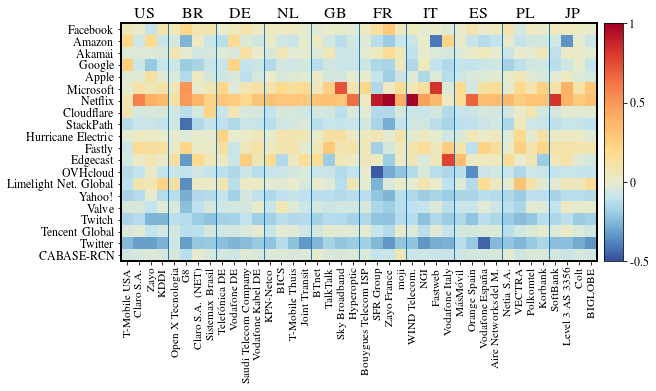


 #####################################
2020_06_01 2021_01_01
#####################################

Missing rnode
asn
31334    Vodafone Kabel Deutschland GmbH
Name: name, dtype: object
Weight of Grr is  0.0008044723206981185
Weight of Gpr is  0.4646065907361136
Weight of Gqr is  0.5345890230130338
Weight of GR is  1.0000000860698455
Weight of Grr is  0.0007351108896087718
Weight of Gpr is  0.49931146203064136
Weight of Gqr is  0.49995345550425657
Weight of GR is  1.0000000284245067
-----------------------------------
HELP FOR DATE 2021_01_01_2020_06_01
----------------------------------- 


CAPPED LINKS
Positive changes capped by vmax =  1.0
('Cloudflare', 'G8', 1.0932120195842912)
('Cloudflare', 'Zayo France', 1.338195252260892)
Negative changes capped by vmin =  -0.5

TOP BOT CHANGES
Top negative changes [('Twitter', 'Zayo France', -0.43600096977483627), ('Twitter', 'G8', -0.3452775918160527), ('Twitter', 'Saudi Telecom Company', -0.3053279053544841), ('Apple', 'Hyperoptic', -0.2951

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


Akamai                   9.606368
Google                   4.820927
Cloudflare               4.481774
Amazon                   2.647519
Microsoft                2.643944
Hurricane Electric       1.661277
Facebook                 0.484564
CABASE-RCN               0.147664
Limelight Net. Global   -0.852518
Netflix                 -1.000162
Fastly                  -1.461386
OVHcloud                -1.710553
Tencent Global          -1.819925
Edgecast                -1.907288
Twitch                  -2.379844
StackPath               -2.894467
Valve                   -4.689606
Yahoo!                  -4.815393
Apple                   -5.583265
Twitter                 -5.747584
dtype: float64


COUNTRY INVESTMENTS


FR    0.697854
GB    0.537988
BR   -0.004771
ES   -0.090552
NL   -0.228187
PL   -0.429292
US   -0.511092
JP   -0.560083
DE   -1.056593
IT   -1.096645
dtype: float64


HYPERGIANTS INVESTMENTS IN COUNTRY


0         1         2         3         4  \
Facebook                NL 0.32   GB 0.26   BR 0.23   PL 0.13   ES 0.03   
Amazon                  FR 0.60   ES 0.39   BR 0.38   US 0.26   PL 0.20   
Akamai                  BR 1.52   PL 1.28   GB 1.16   ES 1.16   NL 1.09   
Google                  DE 0.73   ES 0.72   FR 0.68   GB 0.58   US 0.53   
Apple                  FR -0.24  BR -0.49  JP -0.53  IT -0.54  DE -0.56   
Microsoft               IT 0.65   JP 0.47   PL 0.43   ES 0.41   FR 0.22   
Netflix                 GB 0.26   IT 0.16   JP 0.05  NL -0.08  PL -0.10   
Cloudflare              FR 2.08   BR 1.25   ES 0.48   NL 0.27   US 0.20   
StackPath               ES 0.15   FR 0.09  BR -0.14  GB -0.39  IT -0.41   
Hurricane Electric      FR 0.36   US 0.33   JP 0.29   IT 0.27   NL 0.16   
Fastly                  BR 0.07  DE -0.03  ES -0.05  IT -0.09  GB -0.10   
Edgecast                FR 0.08   BR 0.05  US -0.09  DE -0.13  GB -0.20   
OVHcloud                NL 0.15  JP -0.03  ES -0.09  BR -0.10  DE -0.14   
Limelight Net. Global   BR 0.38   DE 0.17   ES 0.13  US -0.16  IT -0.17   
Yahoo!                 FR -0.29  DE -0.39  IT -0.46  US -0.49  NL -0.51   
Valve                   FR 0.06  ES -0.46  NL -0.48  US -0.48  BR -0.52   
Twitch                  IT 0.14  DE -0.10  JP -0.12  GB -0.16  ES -0.21   
Tencent Global          ES 0.48   FR 0.04  DE -0.16  GB -0.20  IT -0.21   
Twitter                NL -0.40  IT -0.46  US -0.47  GB -0.50  JP -0.53   
CABASE-RCN              GB 0.16   FR 0.08   JP 0.07  NL -0.00  US -0.01   

                              5         6         7         8         9  
Facebook               US -0.01  DE -0.03  JP -0.03  FR -0.13  IT -0.28  
Amazon                  DE 0.18   IT 0.18   NL 0.18   GB 0.17   JP 0.11  
Akamai                  FR 0.81   US 0.74   IT 0.69   JP 0.67   DE 0.49  
Google                  PL 0.43   JP 0.39   IT 0.36   NL 0.22   BR 0.18  
Apple                  ES -0.58  PL -0.59  US -0.60  NL -0.70  GB -0.76  
Microsoft               US 0.21   NL 0.20   DE 0.13  BR -0.01  GB -0.06  
Netflix                US -0.10  DE -0.13  ES -0.28  BR -0.32  FR -0.45  
Cloudflare              PL 0.20   IT 0.14  GB -0.00  DE -0.05  JP -0.09  
StackPath              NL -0.42  US -0.43  PL -0.44  DE -0.44  JP -0.47  
Hurricane Electric      GB 0.08   ES 0.07   PL 0.04   BR 0.03   DE 0.03  
Fastly                 JP -0.10  FR -0.23  US -0.27  NL -0.32  PL -0.34  
Edgecast               IT -0.28  NL -0.31  JP -0.31  ES -0.32  PL -0.38  
OVHcloud               PL -0.22  IT -0.23  GB -0.31  US -0.31  FR -0.42  
Limelight Net. Global  PL -0.17  NL -0.20  JP -0.20  GB -0.27  FR -0.36  
Yahoo!                 ES -0.51  JP -0.52  BR -0.53  PL -0.54  GB -0.58  
Valve                  DE -0.52  GB -0.54  JP -0.56  IT -0.57  PL -0.62  
Twitch                 US -0.30  FR -0.31  NL -0.36  PL -0.46  BR -0.50  
Tencent Global         NL -0.23  JP -0.24  US -0.35  PL -0.47  BR -0.49  
Twitter                DE -0.53  PL -0.54  FR -0.68  ES -0.76  BR -0.89  
CABASE-RCN             DE -0.01  IT -0.02  ES -0.03  BR -0.04  PL -0.05


COUNTRY INVESTMENTS
US


Akamai                   0.738645
Google                   0.531636
Hurricane Electric       0.330604
Amazon                   0.263306
Microsoft                0.206051
Cloudflare               0.201872
CABASE-RCN              -0.008480
Facebook                -0.014268
Edgecast                -0.094952
Netflix                 -0.102832
Limelight Net. Global   -0.159270
Fastly                  -0.266974
Twitch                  -0.304393
OVHcloud                -0.311279
Tencent Global          -0.347964
StackPath               -0.426719
Twitter                 -0.467607
Valve                   -0.480298
Yahoo!                  -0.487226
Apple                   -0.600494
dtype: float64

BR


Akamai                   1.517014
Cloudflare               1.248803
Limelight Net. Global    0.379167
Amazon                   0.375908
Facebook                 0.227330
Google                   0.184714
Fastly                   0.068638
Edgecast                 0.050962
Hurricane Electric       0.031291
Microsoft               -0.014790
CABASE-RCN              -0.041854
OVHcloud                -0.100481
StackPath               -0.142951
Netflix                 -0.317680
Apple                   -0.489359
Tencent Global          -0.491616
Twitch                  -0.497204
Valve                   -0.516622
Yahoo!                  -0.534243
Twitter                 -0.888380
dtype: float64

DE


Google                   0.731254
Akamai                   0.488811
Amazon                   0.183918
Limelight Net. Global    0.165387
Microsoft                0.132779
Hurricane Electric       0.029814
CABASE-RCN              -0.010898
Facebook                -0.025439
Fastly                  -0.029368
Cloudflare              -0.046202
Twitch                  -0.096154
Netflix                 -0.128581
Edgecast                -0.131148
OVHcloud                -0.136658
Tencent Global          -0.160244
Yahoo!                  -0.394919
StackPath               -0.443145
Valve                   -0.520278
Twitter                 -0.534480
Apple                   -0.559507
dtype: float64

NL


Akamai                   1.090324
Facebook                 0.320440
Cloudflare               0.273627
Google                   0.222834
Microsoft                0.204711
Amazon                   0.176419
Hurricane Electric       0.162049
OVHcloud                 0.151504
CABASE-RCN              -0.001383
Netflix                 -0.080174
Limelight Net. Global   -0.199266
Tencent Global          -0.225421
Edgecast                -0.310383
Fastly                  -0.320741
Twitch                  -0.359137
Twitter                 -0.402158
StackPath               -0.420840
Valve                   -0.476587
Yahoo!                  -0.505869
Apple                   -0.703582
dtype: float64

GB


Akamai                   1.161521
Google                   0.578646
Facebook                 0.260482
Netflix                  0.255281
Amazon                   0.167720
CABASE-RCN               0.158313
Hurricane Electric       0.079670
Cloudflare              -0.002481
Microsoft               -0.063063
Fastly                  -0.101465
Twitch                  -0.158527
Tencent Global          -0.198645
Edgecast                -0.202862
Limelight Net. Global   -0.270118
OVHcloud                -0.307754
StackPath               -0.386168
Twitter                 -0.497516
Valve                   -0.542653
Yahoo!                  -0.576287
Apple                   -0.759576
dtype: float64

FR


Cloudflare               2.084431
Akamai                   0.810638
Google                   0.677587
Amazon                   0.596302
Hurricane Electric       0.359131
Microsoft                0.222757
StackPath                0.094496
CABASE-RCN               0.083225
Edgecast                 0.079579
Valve                    0.055923
Tencent Global           0.037108
Facebook                -0.130212
Fastly                  -0.228480
Apple                   -0.240732
Yahoo!                  -0.289628
Twitch                  -0.314872
Limelight Net. Global   -0.360973
OVHcloud                -0.424381
Netflix                 -0.454368
Twitter                 -0.678311
dtype: float64

IT


Akamai                   0.690426
Microsoft                0.653799
Google                   0.356172
Hurricane Electric       0.271578
Amazon                   0.181111
Netflix                  0.156536
Twitch                   0.138283
Cloudflare               0.135063
CABASE-RCN              -0.016995
Fastly                  -0.088077
Limelight Net. Global   -0.166487
Tencent Global          -0.205604
OVHcloud                -0.234698
Edgecast                -0.283435
Facebook                -0.283705
StackPath               -0.406267
Twitter                 -0.456179
Yahoo!                  -0.457645
Apple                   -0.535039
Valve                   -0.568910
dtype: float64

ES


Akamai                   1.160464
Google                   0.722617
Tencent Global           0.481268
Cloudflare               0.478763
Microsoft                0.410311
Amazon                   0.390173
StackPath                0.153443
Limelight Net. Global    0.130700
Hurricane Electric       0.067575
Facebook                 0.034406
CABASE-RCN              -0.028039
Fastly                  -0.047710
OVHcloud                -0.094567
Twitch                  -0.210275
Netflix                 -0.278535
Edgecast                -0.321401
Valve                   -0.462607
Yahoo!                  -0.507143
Apple                   -0.580731
Twitter                 -0.756899
dtype: float64

PL


Akamai                   1.283316
Google                   0.428963
Microsoft                0.425024
Amazon                   0.201147
Cloudflare               0.195042
Facebook                 0.125231
Hurricane Electric       0.041531
CABASE-RCN              -0.053271
Netflix                 -0.101850
Limelight Net. Global   -0.168250
OVHcloud                -0.220692
Fastly                  -0.343184
Edgecast                -0.380453
StackPath               -0.441338
Twitch                  -0.457844
Tencent Global          -0.466070
Twitter                 -0.536868
Yahoo!                  -0.540191
Apple                   -0.587059
Valve                   -0.618138
dtype: float64

JP


Akamai                   0.665211
Microsoft                0.466364
Google                   0.386503
Hurricane Electric       0.288036
Amazon                   0.111514
CABASE-RCN               0.067045
Netflix                  0.052041
Facebook                -0.029701
OVHcloud                -0.031547
Cloudflare              -0.087143
Fastly                  -0.104024
Twitch                  -0.119723
Limelight Net. Global   -0.203409
Tencent Global          -0.242736
Edgecast                -0.313194
StackPath               -0.474978
Yahoo!                  -0.522242
Apple                   -0.527186
Twitter                 -0.529186
Valve                   -0.559437
dtype: float64

diff sum -8.367955589928611


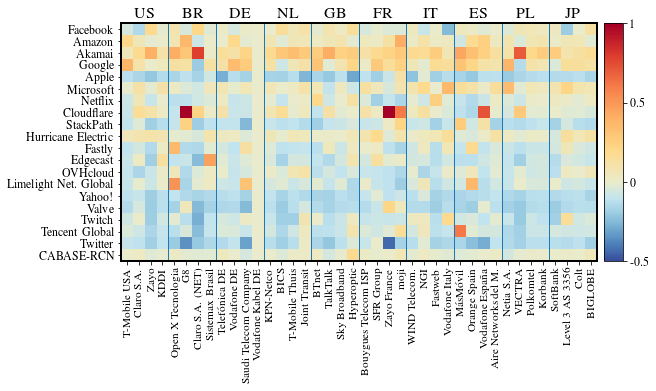

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

dates = ["2019_01_01", "2019_06_01", "2020_01_01", "2020_06_01", "2021_01_01"]

def insert_rowcol(a, pos):
    
    abis = np.insert(a,pos, np.zeros(a.shape[0]), axis=0)
    ater = np.insert(abis,pos, np.zeros(abis.shape[0]), axis=1)
    
    return ater

def fix_GR(to_fix, to_fill , rnodes):
    """assume to_fix is squared"""
    
    if to_fix.shape[0] == len(rnodes): #nothing to do
        return to_fix
    
    elif to_fix.shape[0] < len(rnodes):
        for index in to_fill:
            to_fix = insert_rowcol(to_fix, index)
    
    else:
        print("Error!")
        
    assert(to_fix.shape[0] == len(rnodes))
    return to_fix

for k in range(len(dates)-1):
    print("\n #####################################")
    print(dates[k], dates[k+1])
    print("#####################################\n")
    edgelist = open("caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+dates[k]+".txt", "r")
    DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")
    GmatrixStar = pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=True)
    
    edgelist = open("caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+dates[k+1]+".txt", "r")
    DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")
    GmatrixStar_d2 = pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=True)
    
    ##fix part 1: rnodes missing in snapshots. we will compute REGOMAX without them but we need to know they exist
    rnodes_common = rnodes[:topCR] + list(set(rnodes[topCR:]).intersection(set(GmatrixStar)).intersection(set(GmatrixStar_d2)))
    
    to_fill = []
    for j in range(len(rnodes)):
        if rnodes[j] not in rnodes_common:
            to_fill.append(j)
            
    print("Missing rnode")
    for rnode in to_fill:
        print(nodes.loc[nodes.asn==rnodes[rnode],"name"])
        
    Grr, Gpr, Gqr = pygomax.regomax(GmatrixStar, rnodes=rnodes_common, maxiter=300)
    GR = Grr + Gpr + Gqr
    Grr_d2, Gpr_d2, Gqr_d2 = pygomax.regomax(GmatrixStar_d2, rnodes=rnodes_common, maxiter=300)
    GR_d2 = Grr_d2 + Gpr_d2 + Gqr_d2
    
    for j in range(GR.shape[0]):
        GR[j,j] = 0.0
        GR[:,j] /= np.sum(GR[:,j])
    for j in range(GR_d2.shape[0]):
        GR_d2[j,j] = 0.0
        GR_d2[:,j] /= np.sum(GR_d2[:,j])
    
    
    ##fix part 2: adding columns/row to GR. (to have the same number of rnodes as january)
    GR = fix_GR(GR, to_fill , rnodes)
    GR_d2 = fix_GR(GR_d2, to_fill , rnodes)

    
    ##plotting
    fig1, ax = plt.subplots(figsize = (9,12), ncols=1, nrows=1)

    diff = (GR_d2[:topCR,topCR:] - GR[:topCR,topCR:])/GR[:topCR,topCR:]
    
    diff = np.nan_to_num(diff, copy=True, nan=0.0, posinf=0.0, neginf=0.0)

    vmin = -0.5
    vmax = 1.0
    
    ##Helper funcitions
    helpstr = "HELP FOR DATE " + str(dates[k+1])+"_"+str(dates[k])
    print("-"*len(helpstr))
    print(helpstr)
    print("-"*len(helpstr),"\n")
    print_capped(diff)
    print_top_bot_changes(diff)
    print_hypergiants_investments(diff)
    print_country_investments(diff)
    print_hypergiants_investments_in_countries_v1(diff)
    print_hypergiants_investments_in_countries_v2(diff)
    
    print("diff sum", np.sum(diff))
    
    cm = ax.imshow(diff, cmap=cmap_colorblind, norm = MidpointNormalize(vmin, vmax, 0.))

    ax.set_yticks([i for i in range(topCR)])
    ax.set_yticklabels(rnodes_label[:topCR], fontsize=12)
    ax.set_xticks([i for i in range(diff.shape[1])])
    ax.set_xticklabels(rnodes_label[topCR:], rotation=90, fontsize=11.5)
    ax.vlines([-0.5] + [-0.5+np.sum(topKs[:i]) for i in range(len(countries_list))],-0.5, topCR-0.5, linewidth=1.0)

    annotations_label = countries_list
    annotations_pos = [-0.5+np.sum(topKs[:i])+0.5*topKs[i] for i in range(len(countries_list))]
    plt.rc('font',**{'family':'serif','serif':['Times'], 'size':12})
    plt.rc('text', usetex=True)
    for i in range(len(countries_list)):
        ax.annotate(annotations_label[i], (annotations_pos[i],-1), annotation_clip=False, ha="center", fontsize=16)


    plt.setp(ax.spines.values(), linewidth=2.0)

    ##colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.1)
    fig1.colorbar(cm, cax=cax, ticks=[-0.5, 0.0, 0.5, 1.0], orientation='vertical')
    cax.set_yticklabels(['-0.5', '0', '0.5', '1'], ha='left')
    
    plt.show()
    fig1.savefig("Gdiff_"+dates[k+1]+"_"+dates[k]+".pdf", bbox_inches="tight")

binary CMAP